In [1]:
%load_ext autoreload
%autoreload 2
import glob
import json
import numpy as np
import pandas as pd
import import_lakes
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import Ridge, Lasso

In [2]:
df = import_lakes.import_lake(r'./data/lakegreifenctdprofiles_datalakesdownload/*.json')

In [3]:
df['x'].values[0] / 60 /60 - df['x'].values[8] / 60 /60

-24.0

In [6]:
df.sort_values(by="x",inplace=True)

In [7]:
day_df = pd.DataFrame([df.to_numpy()[i*8:(i+1)*8].mean(axis=0) for i in range(len(df)//8)],columns=df.columns)

In [8]:
day_df

,x,z,z1,z2,z3,z4,z5,z6,z7,z8,z9
0,1.593633e+09,9.914375,0.368563,0.250000,70.923749,7.37500,7.953188,14.26250,-0.25000,3.46875,-0.36875
1,1.593719e+09,10.816688,0.376937,0.249563,90.485001,9.22500,8.042875,13.77500,-0.11875,3.69375,0.29375
2,1.593805e+09,10.702438,0.376812,0.249875,79.800000,8.34375,7.987875,11.38125,-0.13750,3.77500,-1.81875
3,1.593892e+09,10.936375,0.378625,0.250000,82.480000,8.55000,8.012750,10.71875,0.00000,3.83125,-1.71250
4,1.593978e+09,10.504125,0.374938,0.249875,79.435624,8.32500,7.973062,10.49375,-0.04375,3.41250,0.51875
...,...,...,...,...,...,...,...,...,...,...,...
791,1.681658e+09,7.729063,339.412498,463.231247,102.089374,9.02500,10.119812,15.81250,1.80000,2.90000,-3.05625
792,1.681831e+09,7.400437,336.993752,463.937496,96.271875,8.71250,10.044563,12.76875,1.86250,2.25625,-3.07500
793,1.682003e+09,7.876125,342.250000,464.543743,95.108749,8.51875,10.219688,15.11875,2.23750,2.82500,-3.25000
794,1.682176e+09,7.771437,341.250000,464.724998,94.716874,8.37500,10.324188,13.72500,2.35000,2.60625,-1.57500


In [9]:
day_df['z6'] = np.maximum(day_df['z6'],3)

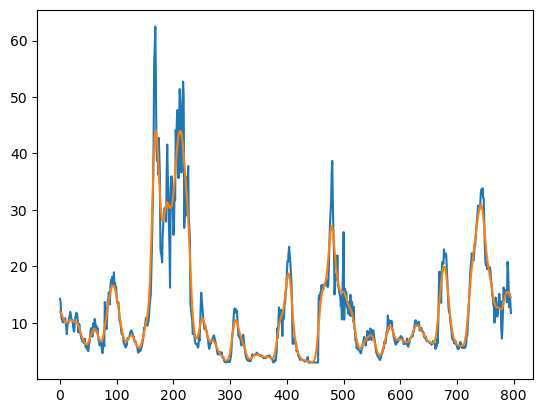

In [10]:
plt.plot(day_df['z6'].values)
plt.plot(gaussian_filter1d(day_df['z6'].values,4))

In [11]:
X = np.arange(0,len(day_df['z6'].values))
Y = gaussian_filter1d(day_df['z6'].values,4)

In [12]:
np.shape(Y)

(796,)

In [13]:
np.shape(Y)

(796,)

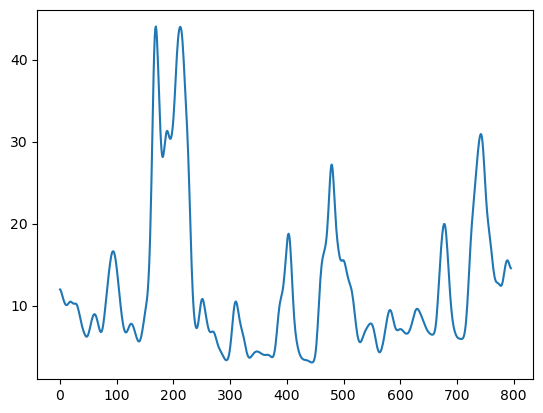

In [14]:
plt.plot(X,Y)

In [15]:
X = np.reshape(X,(len(X),1))

ridge/lasso: train on first 600

In [24]:
z6data = gaussian_filter1d(day_df['z6'].values,4)

In [43]:
chloro = z6data[:600]
n_steps = 14
X_train, Y_train = [], []
for i in range(n_steps, len(chloro)-6):
    X_train.append(chloro[i-n_steps:i])
    Y_train.append(chloro[i+6])

In [44]:
ridgeRegression = Ridge()
lassoRegression = Lasso()
ridgeRegression.fit(X_train, Y_train)
lassoRegression.fit(X_train, Y_train)
predictions_train_ridge = ridgeRegression.predict(X_train)
predictions_train_lasso = lassoRegression.predict(X_train)

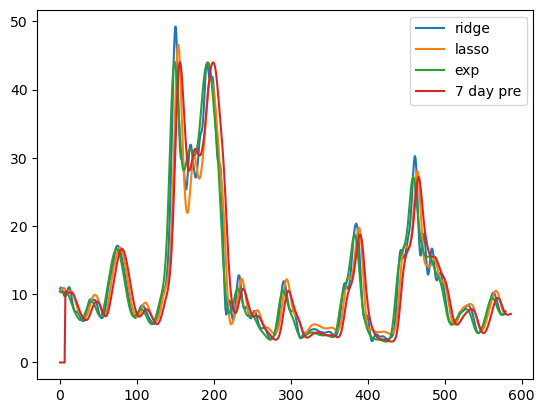

In [45]:
plt.plot(predictions_train_ridge,label="ridge")
plt.plot(predictions_train_lasso,label="lasso")
plt.plot(np.array(Y_train).tolist(),label='exp')
plt.plot([0 for i in range(7)]+[y for y in np.array(Y_train).tolist()],label='7 day pre')
plt.legend()

In [46]:
chloro = z6data[600:]
n_steps = 14
X_test, Y_test = [], []
for i in range(n_steps, len(chloro)-6):
    X_test.append(chloro[i-n_steps:i])
    Y_test.append(chloro[i+6])

In [59]:
len(X_train)

168

In [47]:
predictions_test_ridge = ridgeRegression.predict(X_test)
predictions_test_lasso = lassoRegression.predict(X_test)

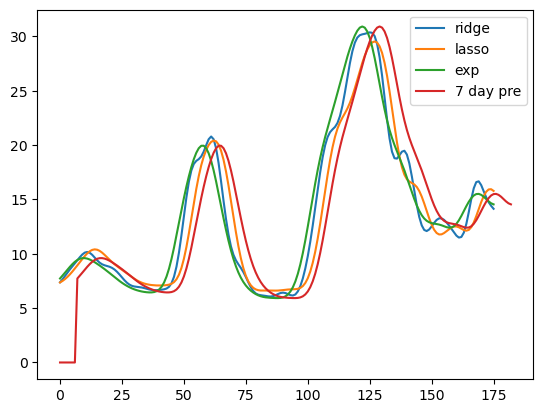

In [48]:
plt.plot(predictions_test_ridge,label="ridge")
plt.plot(predictions_test_lasso,label="lasso")
plt.plot(np.array(Y_test).tolist(),label='exp')
plt.plot([0 for i in range(7)]+[y for y in np.array(Y_test).tolist()],label='7 day pre')
plt.legend()

Plot according to Paul's colour scheme

(-28.950000000000003, 607.95)

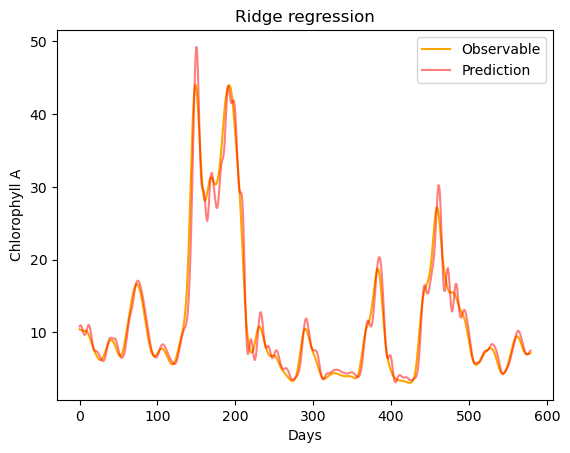

In [53]:
fig, axd = plt.subplot_mosaic([['Prediction7days']])
ax = axd['Prediction7days']
ax.plot(np.array(Y_train).tolist(),label='Observable',color='orange')
ax.plot(predictions_train_ridge,label='Prediction',color='red',alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.set_title("Ridge regression")

plt.legend()
plt.xlim()

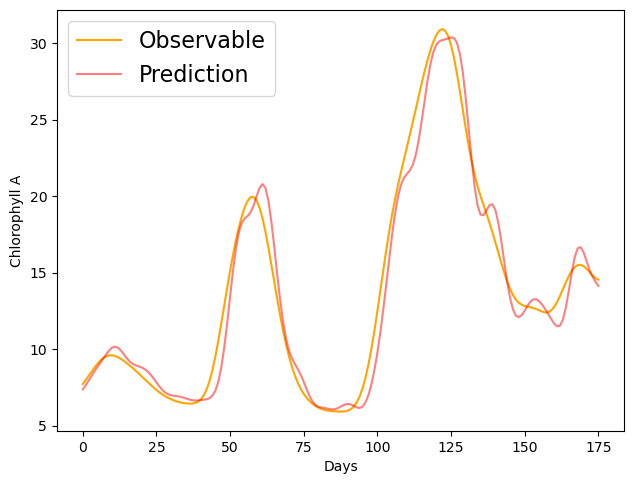

In [54]:
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
ax.plot(np.array(Y_test).tolist(),label='Observable',color='orange')
ax.plot(predictions_test_ridge,label='Prediction',color='red',alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.legend(fontsize=16)

14 days ahead

In [65]:
chloro = z6data[:600]
n_steps = 14
X_train, Y_train = [], []
for i in range(n_steps, len(chloro)-13):
    X_train.append(chloro[i-n_steps:i])
    Y_train.append(chloro[i+13])

In [66]:
len(X_train)

573

In [73]:
ridgeRegression = Ridge(alpha=1.0)
lassoRegression = Lasso()
ridgeRegression.fit(X_train, Y_train)
lassoRegression.fit(X_train, Y_train)
predictions_train_ridge_14days = ridgeRegression.predict(X_train)
predictions_train_lasso_14days = lassoRegression.predict(X_train)

(-28.6, 600.6)

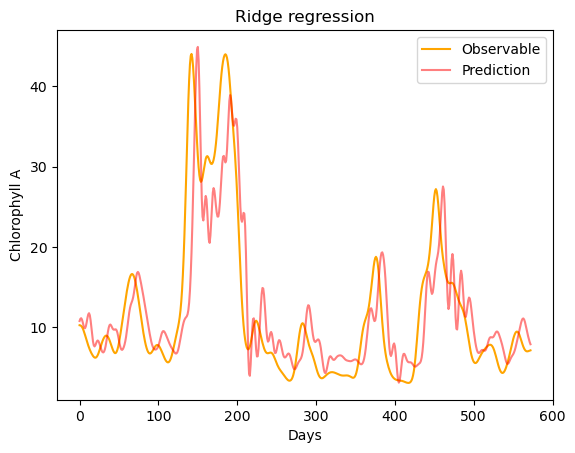

In [72]:
fig, axd = plt.subplot_mosaic([['Prediction14days']])
ax = axd['Prediction14days']
ax.plot(np.array(Y_train).tolist(),label='Observable',color='orange')
ax.plot(predictions_train_ridge_14days,label='Prediction',color='red',alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.set_title("Ridge regression")

plt.legend()
plt.xlim()

(-28.6, 600.6)

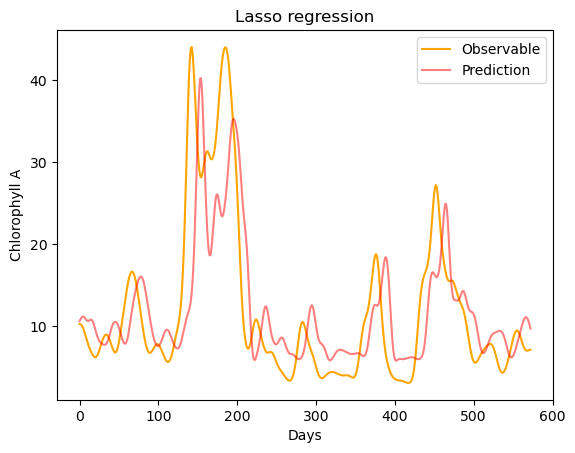

In [74]:
fig, axd = plt.subplot_mosaic([['Prediction14days']])
ax = axd['Prediction14days']
ax.plot(np.array(Y_train).tolist(),label='Observable',color='orange')
ax.plot(predictions_train_lasso_14days,label='Prediction',color='red',alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.set_title("Lasso regression")

plt.legend()
plt.xlim()